In [2]:
import pandas as pd
from string import punctuation
import re
import numpy as np
from setup import *
import glob
import os
import pickle
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop
from keras.utils import to_categorical

AttributeError: module 'pandas' has no attribute 'compat'

## Prepare Embedding Set from a predefined GloVe embedding of Wikipedia 

In [26]:
EMBEDDING_DIM = 50
embeddings_index = {}
f = open('../../glove.6B/glove.6B.50d.txt', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Import the data and condense into one DataFrame
1. glob gets all of the files into a list
1. iterate through the list, load the df into a list of dfs
1. concatenate the list of dfs into single list
1. save the new DF in CSV for later use

In [3]:
file_list = glob.glob("data\Facebook Insights*")

df_list = []

for file in file_list:
    df_list.append(pd.read_csv(file,encoding='iso-8859-1').loc[1:])
    
# for df in df_list:
#     display(df)
    
df = pd.concat(df_list).reset_index()
df.to_csv('All_Files.csv')


In [5]:
df = pd.read_csv('All_Files.csv')
df = df[['Post Message', 'Type', 'Posted', 'Lifetime Post Total Reach','Lifetime Engaged Users']]
df.columns = ['Post', 'Type','Date','Reach','Engaged']

C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (720) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
df.columns

Index(['Post', 'Type', 'Date', 'Reach', 'Engaged'], dtype='object')

# Begin Preprocessing
1. Drop Na columns since they won't contribute, and will not tokenize
1. Tokenize The Sentences 
1. Map words to integers
1. Convert Posts to integer encoded vectors
1. Pad / trim vectors to be specific length

In [7]:
df.dropna(inplace=True)
ndf = pd.merge(df.groupby('Post')['Engaged'].apply(lambda p: max(p)).reset_index(),df[['Post', 'Type', 'Date', 'Reach', 'Engaged']], on = ['Post','Engaged'], how = 'inner')
ndf.drop_duplicates('Post',inplace=True)

In [8]:
display(ndf)

,Post,Engaged,Type,Date,Reach
0,"""An education is just another tool we can use ...",6.000,Status,8/9/16 5:03 PM,174.000
1,"""Despite his brilliance, Einstein couldn't sec...",5.000,Link,3/16/16 6:47 AM,227.000
2,"""Get off the grass!"" Check out some Tarleton ...",172.000,Link,2/11/16 10:05 AM,2796.000
3,"""Healers need healers!"" See what Dr. Merriman ...",4.000,Link,5/18/16 4:18 PM,150.000
4,"""I know who I am. I know what I?m capable of.""...",3.000,Link,2/8/16 9:17 AM,153.000
5,"""It does not matter how slowly you go as long ...",7.000,Photo,6/6/16 5:38 PM,243.000
6,"""My degree is the gateway to __."" Watch our n...",15.000,Link,7/18/16 5:41 AM,328.000
7,"""Tarleton College"" in 1899. https://www.facebo...",24.000,Photo,5/19/16 6:22 AM,426.000
8,"""Tell me about yourself."" How you will answer ...",1.000,Link,6/24/16 5:56 AM,30.000
9,"""The way to get started is to quit talking and...",10.000,Link,8/15/16 8:31 AM,185.000


In [54]:
fdf = ndf.loc[ndf['Reach']>=50].reset_index(drop=True)
display(fdf)
fdf['Prop'] = fdf['Engaged']/fdf['Reach']

,Post,Engaged,Type,Date,Reach
0,"""An education is just another tool we can use ...",6.000,Status,8/9/16 5:03 PM,174.000
1,"""Despite his brilliance, Einstein couldn't sec...",5.000,Link,3/16/16 6:47 AM,227.000
2,"""Get off the grass!"" Check out some Tarleton ...",172.000,Link,2/11/16 10:05 AM,2796.000
3,"""Healers need healers!"" See what Dr. Merriman ...",4.000,Link,5/18/16 4:18 PM,150.000
4,"""I know who I am. I know what I?m capable of.""...",3.000,Link,2/8/16 9:17 AM,153.000
5,"""It does not matter how slowly you go as long ...",7.000,Photo,6/6/16 5:38 PM,243.000
6,"""My degree is the gateway to __."" Watch our n...",15.000,Link,7/18/16 5:41 AM,328.000
7,"""Tarleton College"" in 1899. https://www.facebo...",24.000,Photo,5/19/16 6:22 AM,426.000
8,"""The way to get started is to quit talking and...",10.000,Link,8/15/16 8:31 AM,185.000
9,"""Then, in that hour of deliverance, my heart s...",13.000,Photo,5/29/17 6:01 AM,726.000


For large data sets, sorting the most common used words to the top provides faster integer encoding

In [62]:
fdf['Post'] = fdf['Post'].transform(lambda p : ' '.join([WordNetLemmatizer().lemmatize(x.lower()) for x in word_tokenize(p) if x.lower() not in stopwords.words('english') and x.lower() not in punctuation and x.isalpha()]))
fdf = fdf.loc[fdf['Post'] != 'http']

scaler = MinMaxScaler() # scale the original data to be within 0 to 1
scaler.fit(fdf['Prop'].values.reshape(-1,1))
proportion = scaler.transform(fdf['Prop'].values.reshape(-1,1)).ravel()

MAX_SEQUENCE_LENGTH = 76 # set the max sequence length to pad vectors

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(fdf['Post'])
sequences = tokenizer.texts_to_sequences(fdf['Post'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Found 1720 unique tokens.
Shape of data tensor: (779, 76)


In [163]:
print(fdf['Post'])

0      education another tool use create path towards...
1      despite brilliance einstein could secure acade...
2      get grass check tarleton history learn ca walk...
3      healer need healer see merriman say importance...
4      know know capable motivational word bronco pla...
5      matter slowly go long stop motivationmonday ta...
6      degree gateway watch new graduation video mond...
7                          tarleton college http theater
8      way get started quit talking start disney favo...
9      hour deliverance heart spoke country defender ...
10     two year spam solved gate read tech prediction...
11                                  hard accomplish http
12     givingtuesday global day giving back tuesday n...
13                                                  stem
14                                     tamuspathways way
15     million appropriated loan repayment program me...
16                                      drawing tomorrow
17                    calendar 

In [63]:

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [160]:
midpoints = [sorted(proportion)[int(len(proportion)/3.0)],sorted(proportion)[2*int(len(proportion)/3.0)]]
print(midpoints)

[0.08694140149539209, 0.16989466530750932]


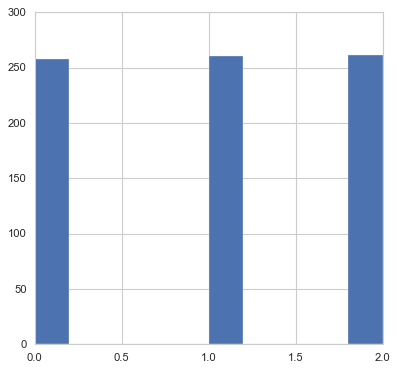

In [161]:
binned = [0 if x <=0.0869 else 1 if x<0.16989466530750932 and x >0.0869 else 2 for x in proportion]
plt.hist(binned)
plt.show()

classes = to_categorical(binned, num_classes=3)

In [162]:

X_train, X_test, y_train, y_test = train_test_split(data, classes, test_size=0.20, random_state=42)

model = Sequential()
model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(10))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(MaxPooling1D(5))  # global max pooling
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop', metrics = ['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=200, batch_size=64)

Train on 623 samples, validate on 156 samples
Epoch 1/200
623/623 [==============================] - 2s 2ms/step - loss: 1.1062 - acc: 0.3291 - val_loss: 1.1061 - val_acc: 0.3718
Epoch 2/200
623/623 [==============================] - 0s 438us/step - loss: 1.0794 - acc: 0.3563 - val_loss: 1.1075 - val_acc: 0.3397
Epoch 3/200
623/623 [==============================] - 0s 452us/step - loss: 1.0557 - acc: 0.3692 - val_loss: 1.1010 - val_acc: 0.3718
Epoch 4/200
623/623 [==============================] - 0s 438us/step - loss: 1.0312 - acc: 0.4157 - val_loss: 1.1412 - val_acc: 0.3333
Epoch 5/200
623/623 [==============================] - 0s 447us/step - loss: 1.0021 - acc: 0.4318 - val_loss: 1.1397 - val_acc: 0.3526
Epoch 6/200
623/623 [==============================] - 0s 444us/step - loss: 0.9785 - acc: 0.4575 - val_loss: 1.1737 - val_acc: 0.3654
Epoch 7/200
623/623 [==============================] - 0s 465us/step - loss: 0.9511 - acc: 0.4783 - val_loss: 1.2112 - val_acc: 0.3654
Epoch 8/200

Epoch 61/200
623/623 [==============================] - 0s 459us/step - loss: 0.8604 - acc: 0.4928 - val_loss: 2.1254 - val_acc: 0.3462
Epoch 62/200
623/623 [==============================] - 0s 562us/step - loss: 0.8606 - acc: 0.4928 - val_loss: 2.1809 - val_acc: 0.3526
Epoch 63/200
623/623 [==============================] - 0s 455us/step - loss: 0.8603 - acc: 0.4912 - val_loss: 2.2030 - val_acc: 0.3526
Epoch 64/200
623/623 [==============================] - 0s 486us/step - loss: 0.8610 - acc: 0.4944 - val_loss: 2.1495 - val_acc: 0.3462
Epoch 65/200
623/623 [==============================] - 0s 415us/step - loss: 0.8608 - acc: 0.4928 - val_loss: 2.1460 - val_acc: 0.3462
Epoch 66/200
623/623 [==============================] - 0s 399us/step - loss: 0.8605 - acc: 0.4944 - val_loss: 2.1733 - val_acc: 0.3590
Epoch 67/200
623/623 [==============================] - 0s 475us/step - loss: 0.8601 - acc: 0.4912 - val_loss: 2.1437 - val_acc: 0.3526
Epoch 68/200
623/623 [==========================

623/623 [==============================] - 0s 447us/step - loss: 0.8592 - acc: 0.4928 - val_loss: 2.6653 - val_acc: 0.3462
Epoch 122/200
623/623 [==============================] - 0s 573us/step - loss: 0.8604 - acc: 0.4928 - val_loss: 2.6676 - val_acc: 0.3462
Epoch 123/200
623/623 [==============================] - 0s 501us/step - loss: 0.8591 - acc: 0.4928 - val_loss: 2.7106 - val_acc: 0.3397
Epoch 124/200
623/623 [==============================] - 0s 415us/step - loss: 0.8606 - acc: 0.4944 - val_loss: 2.7127 - val_acc: 0.3397
Epoch 125/200
623/623 [==============================] - 0s 515us/step - loss: 0.8591 - acc: 0.4928 - val_loss: 2.7069 - val_acc: 0.3462
Epoch 126/200
623/623 [==============================] - 0s 422us/step - loss: 0.8595 - acc: 0.4928 - val_loss: 2.7132 - val_acc: 0.3462
Epoch 127/200
623/623 [==============================] - 0s 428us/step - loss: 0.8598 - acc: 0.4928 - val_loss: 2.7017 - val_acc: 0.3526
Epoch 128/200
623/623 [==============================] 

KeyboardInterrupt: 

In [10]:
# SKIP THIS FOR NOW
fdf['Post'] = fdf['Post'].transform(lambda p : ' '.join([WordNetLemmatizer().lemmatize(x.lower()) for x in word_tokenize(p) if x.lower() not in stopwords.words('english') and x.lower() not in punctuation and x.isalpha()]))
fdf = fdf.loc[fdf['Post'] != 'http']
counts = Counter()
for i,post in enumerate(fdf['Post']):
    text = [x for x in word_tokenize(post)]
    counts.update(text) 
# print(counts)
word_counts = sorted(counts,key=counts.get,reverse=True)
num_words = len(word_counts)
print('Number of words: ' + str(num_words))
# print(word_counts[:5])
word_to_int= {word: ii for ii, word in enumerate(word_counts,1)}
mapped_posts = []
for post in fdf['Post']:
    mapped_posts.append([word_to_int[word] for word in post.split()])

Number of words: 1720


In [11]:
# SKIP THIS FOR NOW
with open('count_dict.txt', 'wb') as handle:
  pickle.dump(word_to_int, handle)

Get the max length to pad vectors. Here we could choose to trim vectors if necessary.

In [12]:
# SKIP THIS FOR NOW
max_seq = 0

for i,x in enumerate(fdf['Post']):
#     print(x)
    if len(x.split()) >= max_seq:
        max_seq = len(x.split())
sequence_length = max_seq
proportion = fdf['Prop']
engagement = fdf['Engaged']
prop_eng = fdf[['Reach','Engaged']]
print(max_seq)

76


In [13]:
# SKIP THIS FOR NOW
padded_sequences = sequence.pad_sequences(mapped_posts, maxlen = max_seq)

Make the test/train set. First we will train on all of the data to check the prediction on itself.

In [14]:
# X_train, X_test, y_train, y_test = padded_sequences, padded_sequences, proportion, proportion

In [47]:
node_parameters = ['embedding','conv','maxpool','flatten','dense','lstm']

nodes = [['embedding', num_words+1,32,max_seq],['conv',16,4,'same','relu'],['maxpool',3],['flatten'],['dense',256,'relu'],['dense',1,'relu']]
compiler = ['mean_squared_error','rmsprop', []]

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, proportion, test_size=0.20, random_state=42)
model = Sequential()
for x in nodes:
    if x[0] is 'embedding':
        model.add(Embedding(input_dim = x[1], output_dim = x[2], input_length = x[3]))
    elif x[0] is 'conv':
        model.add(Conv1D(filters = x[1], kernel_size = x[2], padding = x[3], activation = x[4]))
    elif x[0] is 'maxpool':
        model.add(MaxPooling1D(pool_size = x[1]))
    elif x[0] is 'flatten':
        model.add(Flatten())
    elif x[0] is 'dense':
        model.add(Dense(units = x[1], activation = x[2]))
callbacks_list = []
model.compile(loss = compiler[0], optimizer = compiler[1], metrics = compiler[2])
print(model.summary())
fit_model = model.fit(X_train,y_train, validation_data = (X_test,y_test), epochs = 200, batch_size=64, callbacks=callbacks_list)
plt.plot(fit_model.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()        


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 76, 50)            85950     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 76, 16)            3216      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 25, 16)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               102656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 192,079
Trainable params: 106,129
Non-trainable params: 85,950
_________________________________________________________________

InvalidArgumentError: indices[41,72] = 1720 is not in [0, 1719)
	 [[Node: embedding_6/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_6/embeddings/read, embedding_6/Cast)]]

Caused by op 'embedding_6/Gather', defined at:
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-d29c41e839e9>", line 8, in <module>
    model.add(Embedding(len(word_index) + 1,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py", line 467, in add
    layer(x)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\engine\topology.py", line 617, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\layers\embeddings.py", line 138, in call
    out = K.gather(self.embeddings, inputs)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1208, in gather
    return tf.gather(reference, indices)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1179, in gather
    validate_indices=validate_indices, name=name)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\sw_hutyra\AppData\Local\Continuum\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): indices[41,72] = 1720 is not in [0, 1719)
	 [[Node: embedding_6/Gather = Gather[Tindices=DT_INT32, Tparams=DT_FLOAT, validate_indices=true, _device="/job:localhost/replica:0/task:0/cpu:0"](embedding_6/embeddings/read, embedding_6/Cast)]]


In [1]:


X_train, X_test, y_train, y_test = train_test_split(padded_sequences, proportion, test_size=0.20, random_state=42)
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(num_words+1, embedding_vector_length, input_length = max_seq))
model.add(Conv1D(filters=16, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='relu'))
# earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10, verbose=1, mode='auto')
callbacks_list = []#earlystop]
model.compile(loss = 'mean_squared_error', optimizer='rmsprop')
print(model.summary())
fit_model = model.fit(X_train,y_train, validation_split = 0.2, epochs = 200, batch_size=64, callbacks=callbacks_list)
scores = model.evaluate(X_test,y_test,verbose=0)

NameError: name 'train_test_split' is not defined

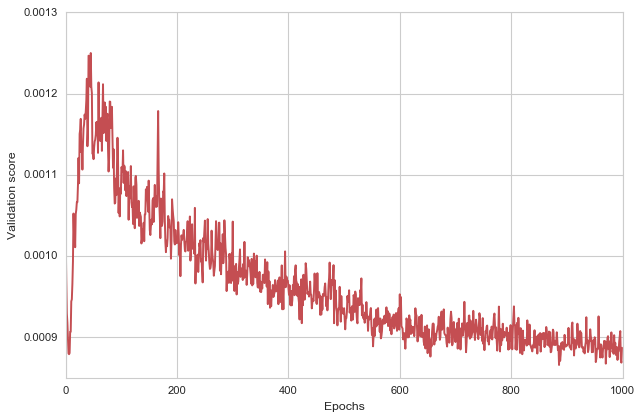

In [77]:
plt.plot(fit_model.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [54]:
model_json = model.to_json()
with open("CCN.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("CCN.h5")
print("Saved model to disk")

Saved model to disk


True